In order to eradicate the inaccuracies associated with each of the above schemes, the following numerical flux was proposed:
\begin{equation}
    F = F^{\text{LO}} + \phi[F^{\text{HI}} - F^{\text{LO}}],
\end{equation}
which contains both a high (HI) and low (LO) order flux and a flux limiter $\phi$. The limiter lies in the range $0 \leq \phi \leq 1$ and acts to vary the overall flux, $F$, locally between low and high order. We consider the limiter function
\begin{equation}
    \phi =
    \begin{cases}
        0 &r \leq 0 \\
        r &0 \leq r \leq 1 \\
        1 &r \geq 1
    \end{cases}
\end{equation}
where $r$ is defined locally as
\begin{equation}
    r_i^n = \min\left\{ \frac{u_i^n - u_{i-1}^n}{u_{i+1}^n - u_i^n} \frac{u_{i+2}^n - u_{i+1}^n}{u_{i+1}^n - u_i^n} \right\}
\end{equation}
and is a measure of the local change in gradient of the solution.

1.  In the neighbourhood of sharp changes in gradient (e.g., shocks, discontinuities), the overall flux, $F$, is predominantly low-order accurate.

    *   Near a sharp change or a discontinuity, the solution's gradient changes abruptly. The solution is not smooth or monotonic. In the presence of oscillations, the gradient can switch signs from one cell to the next. This means the numerator and denominator in the formula for $r$ may have opposite signs causing $r$ to be non-positive.

    *   The given limiter function is defined as $\phi = 0$ for $r \leq 0$. Therefore, in regions of sharp change or oscillation, the limiter is switched off. Substituting $\phi = 0$ into the main flux equation gives $F = F^LO$. The scheme automatically discards the high-order contribution and defaults entirely to the robust, low-order flux.


2.  In the neighbourhood of slight changes in gradient (e.g., smooth regions)
The overall flux, F, is predominantly high-order accurate.

    *   In a region where the solution is smooth, the gradient changes very little from one cell to the next. This means the difference between consecutive points is nearly constant. Thus, the ratio $r$ will be positive and very close to $1$.

    *   According to the limiter function definition, since $r$ is close to $1$, the limiter will also be approximately $1$. Substituting $\phi = 1$ into the main flux equation gives $F = F^HI$. The scheme uses the high-order flux, allowing for a more accurate representation of the solution.

This adaptive variation of the numerical flux F is highly desirable because it combines the best attributes of the low-order and high-order schemes observed previously, while mitigating their respective weaknesses.

Weakness of the low-order Lax-Friedrichs scheme: Whilst this scheme is very stable and did not produce oscillations (it is monotome), it suffered from excessive numerical diffusion, which smeared out both shocks and smooth features like the rarefaction wave, leading to a low-accuracy solution.

Weakness of the high-order Richtmyer scheme: This scheme is much more accurate in smooth regions, capturing the rarefaction wave well. However, it was not monotone and produced spurious, unphysical oscillations (Gibbs phenomenon) around discontinuities, which is a major inaccuracy.

The flux-limiter approach resolves this dilemma. It uses the high-order flux (F ≈ F^HI) in smooth parts of the flow allowing it to achieve high accuracy and avoid excessive smearing. It switches to the low-order flux (F ≈ F^LO) near shocks and sharp gradients to avoid the production of oscillations.

A particular method is the Flux LImited Centred (FLIC) scheme. In this case the high and low order fluxes are defined as
\begin{align}
    F^{\text{HI}} &= F^{\text{Ri}} \\
    F^{\text{LO}} &= \frac{1}{2} [F^{\text{LF}} + F^{\text{Ri}}].
\end{align}

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def analytical_solution(x, t):
    rarefaction_left = 1.0 - t
    rarefaction_right = 1.0 + 0.5 * t
    shock_pos = 2.0 + 0.25 * t

    return np.piecewise(x,
        [
            x < rarefaction_left,
            (x >= rarefaction_left) & (x <= rarefaction_right),
            (x > rarefaction_right) & (x < shock_pos),
            x >= shock_pos
        ],
        [
            -1.0,
            lambda x_in: (x_in - 1.0) / t, # Solution in rarefaction fan
            0.5,
            0.0
        ]
    )

In [21]:
def physical_flux(u):
    return 0.5 * u**2

def lax_friedrichs_flux(uL, uR, dx, dt):
    fL = physical_flux(uL)
    fR = physical_flux(uR)
    return 0.5 * (fL + fR) - 0.5 * (dx / dt) * (uR - uL)

def richtmyer_flux(uL, uR, dx, dt):
    u_intermediate = 0.5 * (uL + uR) - 0.5 * (dt / dx) * (physical_flux(uR) - physical_flux(uL))
    return physical_flux(u_intermediate)

def set_initial_conditions(x):
    '''
    Sets the initial piecewise condition based on the spatial grid x.
    Returns a new array for the initial state u0.
    '''
    u0 = np.zeros_like(x)
    u0[x < 1.0] = -1.0
    u0[(x >= 1.0) & (x < 2.0)] = 0.5
    u0[x >= 2.0] = 0.0
    return u0

def apply_boundary_conditions(u):
    '''
    Applies out-flow boundary conditions.
    Returns a new array with boundary ghost cells updated.
    '''
    u_bc = u.copy()
    u_bc[0] = u_bc[1]   # Left boundary
    u_bc[-1] = u_bc[-2] # Right boundary
    return u_bc

In [22]:
def advance_step_flic(u, dx, dt):
    """
    Performs a single time step update using the FLIC scheme.
    Returns the solution at the next time level.
    """
    u_bc = apply_boundary_conditions(u)

    # Calculate the low and high order fluxes at all interfaces
    uL = u_bc[:-1]
    uR = u_bc[1:]
    F_lf = lax_friedrichs_flux(uL, uR, dx, dt)
    F_ri = richtmyer_flux(uL, uR, dx, dt)

    F_LO = 0.5 * (F_lf + F_ri)
    F_HI = F_ri

    # Calculate the ratio of gradients 'r' for each cell (i)
    epsilon = 1e-9
    grad_forward = u_bc[2:] - u_bc[1:-1]
    grad_backward = u_bc[1:-1] - u_bc[:-2]

    r = grad_backward / (grad_forward + epsilon)

    # Calculate the limiter 'phi' based on r
    phi = np.maximum(0, np.minimum(1, r))

    # Calculate the limited flux for each interface (i + 1/2)
    F = F_LO[1:] + phi * (F_HI[1:] - F_LO[1:])

    # We also need the flux at the first interface, where 'r' is not defined.
    # A common practice is to use the low-order flux at the boundary.
    F_final = np.insert(F, 0, F_LO[0])

    # Update the solution
    u_next = u.copy()
    u_next[1:-1] = u[1:-1] - (dt / dx) * (F_final[1:] - F_final[:-1])

    return u_next

def solve(x, u0, t_final, cfl):
    '''
    Main solver function that marches the solution forward in time.
    '''
    dx = x[1] - x[0]
    t = 0.0
    u = u0.copy()

    while t < t_final:
        max_speed = np.max(np.abs(u))
        dt = cfl * dx / max_speed if max_speed > 0 else 1e-4
        dt = min(dt, t_final - t)

        u = advance_step_flic(u, dx, dt)

        t += dt
    return u

def plot_results(x, u_initial, u_numerical, t_final):
    '''
    Generates a plot comparing the numerical and exact solutions.
    '''
    u_exact = analytical_solution(x, t_final)

    plt.figure(figsize=(8, 5))
    plt.title(f'Lax-Friedrichs Solution vs. Exact Solution at $t = {t_final}$')
    plt.xlabel(f'$x$')
    plt.ylabel(f'$u(x, t)$')

    plt.plot(x, u_initial, 'k--', label='Initial Condition (t=0)')
    plt.plot(x, u_numerical, 'b-o', markersize=4, label='Numerical Solution')
    plt.plot(x, u_exact, 'r-', linewidth=2.5, label='Exact Solution')

    plt.grid(True)
    plt.xlim(np.min(x), np.max(x))
    plt.ylim(-1.1, 0.6)
    plt.legend()
    plt.show()

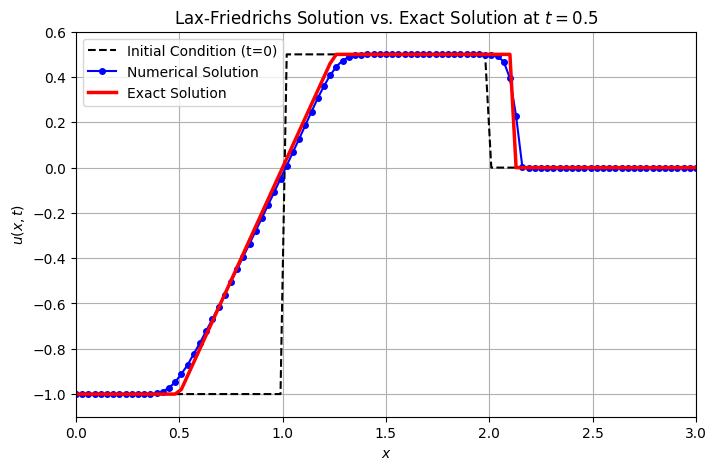

In [23]:
J = 101
x_min, x_max = 0.0, 3.0
t_final = 0.5
cfl = 0.8

x = np.linspace(x_min, x_max, J)
u0 = set_initial_conditions(x)

u_final_flic = solve(x, u0, t_final, cfl)
plot_results(x, u0, u_final_flic, t_final)

The numerical solution from the FLIC scheme shows excellent agreement with the exact analytical solution.

1.   Rarefaction wave: The rarefaction fan (the sloped region from $x=0.5$ to $x=1.25$) is captured with high accuracy. The linear profile is well-resolved, and the corners at the top and bottom of the fan are much sharper than in the Lax-Friedrichs solution.

2.   Shock wave: The shock front at $x=2.125$ is represented as a sharp, clean discontinuity, transitioning over just one or two grid cells. It is captured without any of the spurious oscillations that were present in the Richtmyer scheme's solution. The constant states on either side of the shock are flat and correct.


The FLIC scheme has, to a very large extent, successfully eliminated the undesirable features of both the low-order (Lax-Friedrichs) and high-order (Richtmyer) methods.

1.  Elimination of numerical diffusion: The primary weakness of the Lax-Friedrichs scheme was its excessive numerical diffusion, which resulted in a "smeared" or "blurred" solution. The shock was spread over many grid cells, and the rarefaction wave was rounded.

2.  Elimination of dispersion: The primary weakness of the Richtmyer scheme was its lack of monotonicity, which produced unphysical oscillations (overshoots and undershoots) around the shock wave.

The FLIC scheme successfully achieves the goal of a high-resolution method by adaptively using the best qualities of the previous two schemes. It retains the high accuracy of the Richtmyer scheme in smooth regions of the flow and the robustness and stability of the Lax-Friedrichs scheme in regions of sharp gradients or discontinuities.